In [1]:
from modules import sim_spectra as simu
from modules import solve_sdos as slvsdos
from modules import solve_sdos_adv as slvadv
from scipy.sparse.linalg import lsmr as lsmr
from scipy.optimize import curve_fit
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Generating a test DOS

<IPython.core.display.Javascript object>


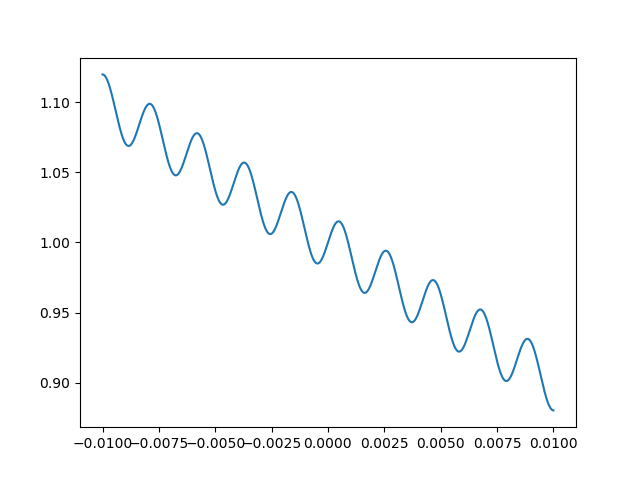

In [2]:
amp=.02 ; freq=3000.
E=linspace(-0.01,0.01,1000)
figure()
plot(E,1-10*E+amp*sin(freq*E))

## Generating simulated dI/dV

<IPython.core.display.Javascript object>


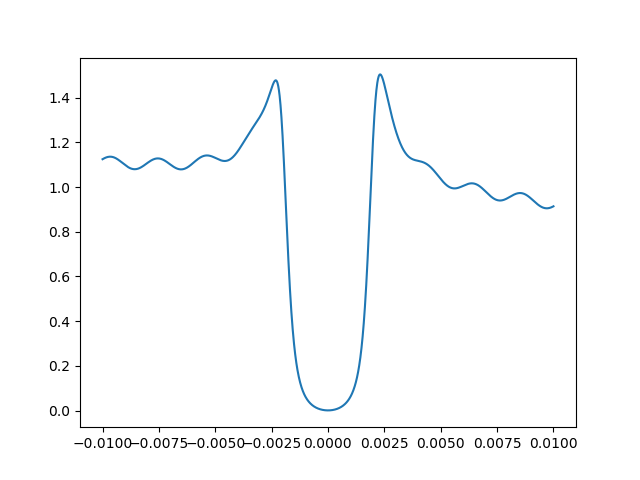

In [3]:
gamma=3e-4 ; delta=2e-3 ; T=1.0
iv,es=simu.sim_sdos(gamma,delta,T,-0.01,0.01,amp=amp,freq=freq)
figure()
plot(iv[0],iv[1])

# Recovering test sample DOS using old way of $(C^tC)^{-1}C^t\rho_s$ 

<IPython.core.display.Javascript object>


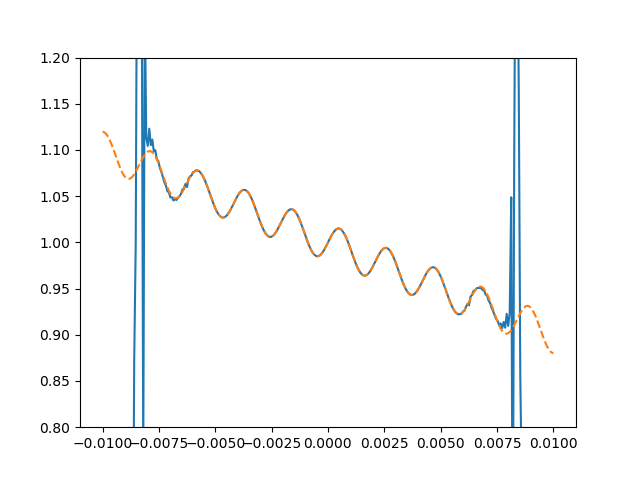

(0.8, 1.2)

In [5]:
E,sdos_true,C=slvsdos.get_sdos(iv[0],iv[1],gamma,delta,T,E_sampling=300,rcond=1e-14)

figure()
plot(E,sdos_true)
plot(es[0],es[1],"--")
ylim(0.8,1.2)

# Recovered test sample DOS for a bad guess of gamma, delta, T

<IPython.core.display.Javascript object>


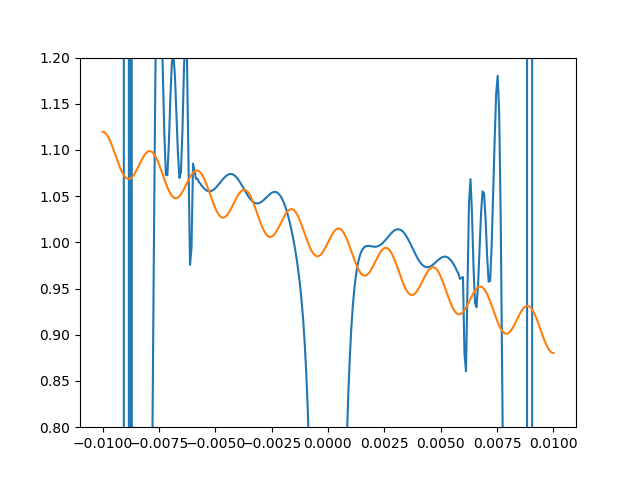

(0.8, 1.2)

In [6]:
guess=[8e-5,1.4e-3,1.8]
lb=[5e-5,1e-3,1.5]
ub=[5e-4,1.5e-3,2.5]
E,sdos_bad,C=slvsdos.get_sdos(iv[0],iv[1],guess[0],guess[1],guess[2],E_sampling=300,rcond=1e-14)
figure()
plot(E,sdos_bad)
plot(es[0],es[1])
ylim(0.8,1.2)

# Making the matrix inversion faster using lsmr function

In [7]:
guess=[1e-5,3e-3,1.]
lb=[1e-6,1e-3,0.]
ub=[5e-4,5e-3,3.]

Ep,C=slvsdos.get_mat(iv[0],guess[0],guess[1],guess[2])
x=lsmr(C,iv[1],atol=1e-4,btol=1e-4)

In [8]:
rec_dIdV=np.array(C*np.transpose(np.matrix(x[0]))).flatten()

<IPython.core.display.Javascript object>


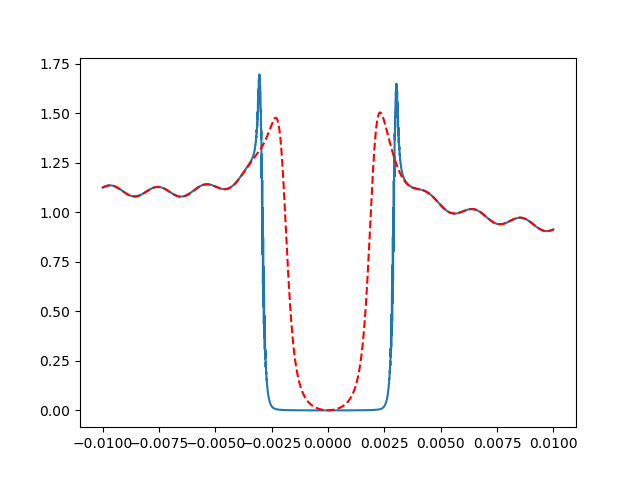

<IPython.core.display.Javascript object>


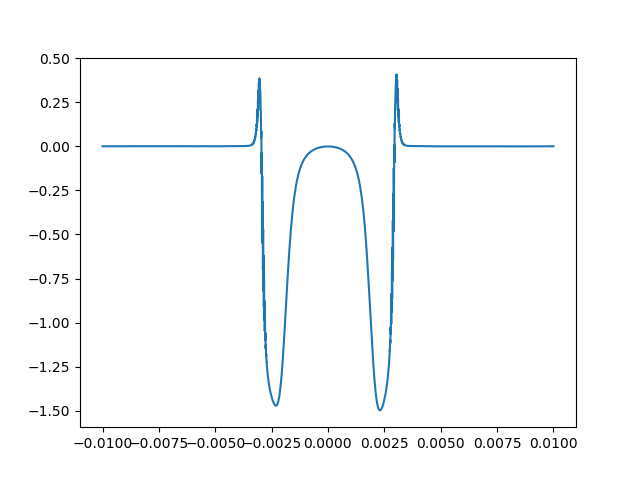

<IPython.core.display.Javascript object>


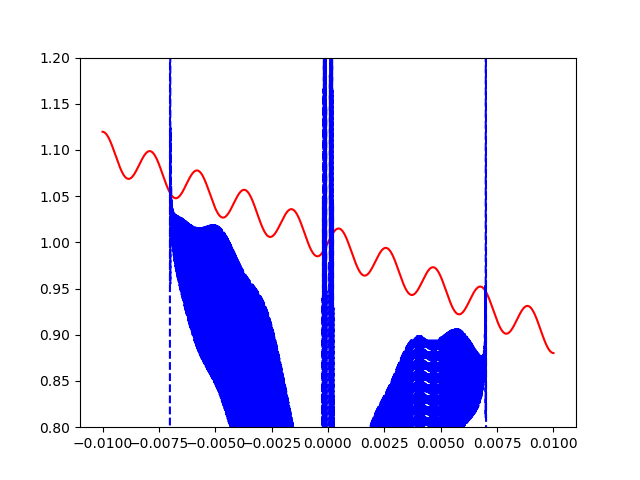

(0.8, 1.2)

In [9]:
figure()
plot(iv[0],rec_dIdV)
plot(iv[0],iv[1],"r--")

figure()
plot(iv[0],rec_dIdV-iv[1])

figure()
plot(es[0],es[1],"r-")
plot(Ep,x[0],"b--")
ylim(0.8,1.2)


# Using curve_fit function to optimize values of gamma, delta, T

In [11]:
def get_rec_dIdV(V, gamma, delta, T, dIdV, E_sampling=3000):
    E,C=slvsdos.get_mat(V,gamma, delta, T,E_sampling=E_sampling)
    sdos=lsmr(C,dIdV,atol=1e-3,btol=1e-3)[0]
    recon_dIdV=np.array(C*np.transpose(np.matrix(sdos))).flatten()
    return recon_dIdV

def get_params(V,dIdV,guess,lb,ub,err=[],E_sampling=3000):
    fn = lambda x,gamma,delta,T: get_rec_dIdV(x,gamma,delta,T,dIdV=dIdV,E_sampling=E_sampling)
    if np.size(err)==0:
        par,par_cov=curve_fit(fn,V,dIdV,p0=guess,bounds=[lb,ub])
    else:
        par,par_cov=curve_fit(fn,V,dIdV,p0=guess,bounds=[lb,ub],sigma=err)
    return par

## specifying error in data for the curve_fit function, error proportional to dIdV in <3meV, higher error in higher bias

<IPython.core.display.Javascript object>


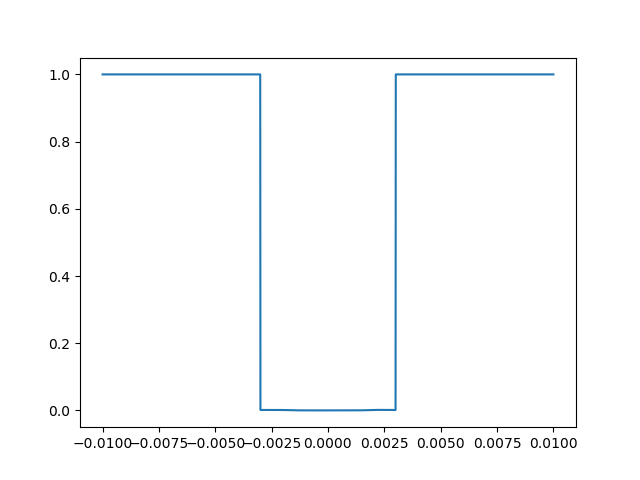

In [12]:
err=np.ones(np.size(iv[0]))
err=iv[1]*0.001
err[abs(iv[0])>0.003]=1.
figure()
plot(iv[0],err)
#semilogy()

## Getting parameters using above error distribution of data

In [13]:
guess=[1e-5,3e-3,1.]
lb=[1e-6,1e-3,0.]
ub=[5e-4,5e-3,3.]
par=get_params(iv[0],iv[1],guess,lb,ub,err=err,E_sampling=300)

## using parameters from above finding reconstructed sdos

<IPython.core.display.Javascript object>


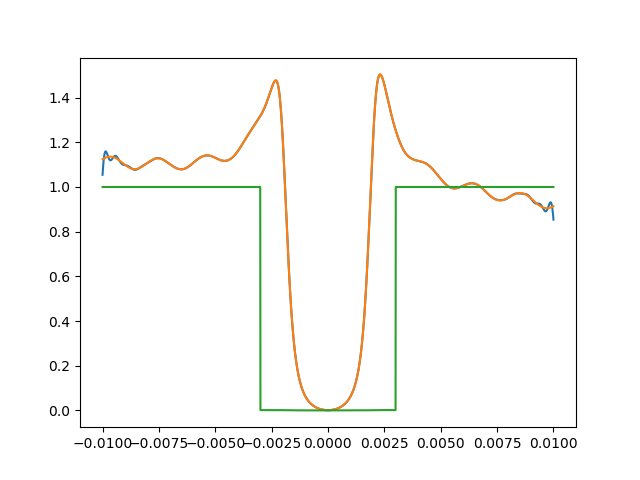

<IPython.core.display.Javascript object>


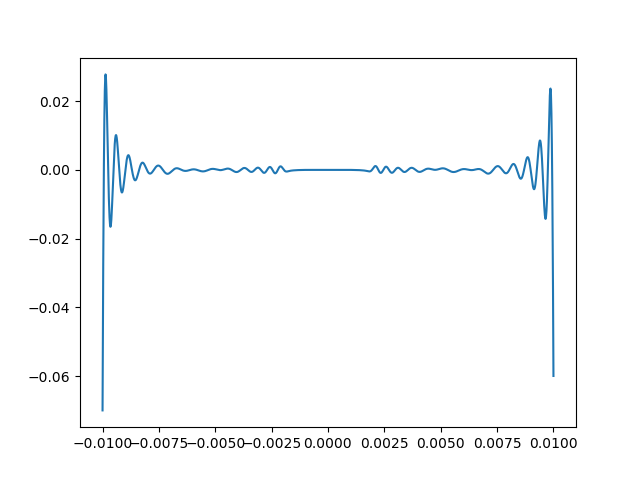

<IPython.core.display.Javascript object>


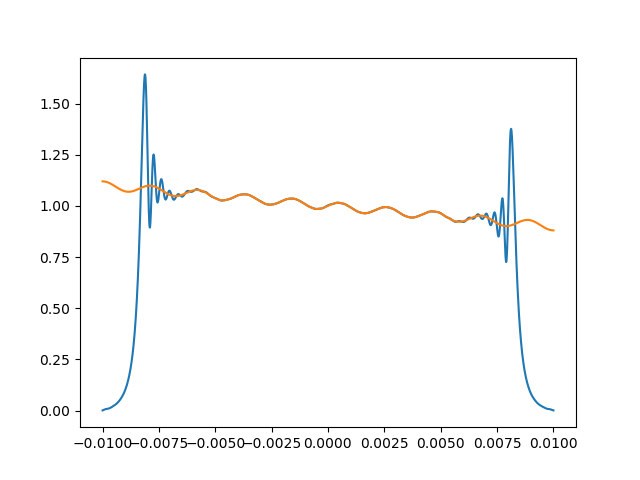

In [28]:
Ep,C=slvsdos.get_mat(iv[0],par[0],par[1],par[2])
rec_sdos=lsmr(C,iv[1],atol=1e-4,btol=1e-4)[0]
figure()
plot(iv[0],get_rec_dIdV(iv[0],par[0],par[1],par[2],iv[1],E_sampling=3000))
plot(iv[0],iv[1])
plot(iv[0],err/max(err))

figure()
plot(iv[0],get_rec_dIdV(iv[0],par[0],par[1],par[2],iv[1],E_sampling=3000)-iv[1])

figure()
plot(Ep,rec_sdos)
plot(es[0],es[1])